In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST

In [5]:
print(torch.__version__)

1.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
#import os
#os.chdir("/content/drive/My Drive") 
import ra
#import complexLayers


In [3]:
dataset = ra.read('atomsroa.ra')
train_data = torch.tensor(dataset)

In [4]:
train_data = train_data.imag
train_data =  torch.transpose(train_data, 0, 1).unsqueeze(1)

In [5]:
labelset = ra.read('paramsroa.ra')
train_label1 = torch.tensor(labelset)

In [6]:
dataset1 = ra.read('atoms.ra')
traindata1 = torch.tensor(dataset1)
traindata1 = traindata1.imag
traindata1 =  torch.transpose(traindata1, 0, 1).unsqueeze(1)
label1 = ra.read('params.ra')
label1 = torch.tensor(label1)

In [ ]:
print(traindata1)
print(train_data)

In [7]:
print(traindata1.shape)
train_data.shape

torch.Size([108056, 1, 1000])


torch.Size([108056, 1, 1000])

In [8]:
alldata = torch.cat((train_data,traindata1),0)

In [9]:
labels1 = torch.cat((train_label1[:-1,:],label1[:-1,:]),1)

In [10]:
print(labels1)
print(labels1.shape)
print(train_label1.shape)

tensor([[ 100.,  110.,  120.,  ..., 3980., 3990., 4000.],
        [  20.,   20.,   20.,  ..., 2000., 2000., 2000.]], dtype=torch.float64)
torch.Size([2, 216112])
torch.Size([3, 108056])


In [10]:
labels1 = torch.transpose(labels1, 0, 1)
print(labels1.shape)

torch.Size([216112, 2])


In [11]:
import torch.utils.data as data
train_dataset = data.TensorDataset(alldata,labels1)

In [ ]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=10).fit_transform(train_data)

In [ ]:
pca = PCA(n_components=10)
pca.fit(train_data)

print(pca.explained_variance_ratio_.shape)
print(pca.components_.shape)
print(pca.singular_values_.shape)
print(pca.mean_.shape)

In [ ]:
train_data = torch.tensor(X_reduced)

In [12]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [140000, 60000 ,16112])

We found that the network model with smallest
average error for validation data consists of 3 convolutional layers (kernel size = 3, stride
size = 2), each followed by a rectified linear unit (ReLU) activation function. The number
of the feature maps per convolutional layer is increasing, from 32 in the first to 128 in
the last. After convolution an average pooling layer follows with the same size as the
stride size. The last layer is fully connected, with 2 outputs. 

In [13]:

# define baseline model
def _batch_norm(x):
  eps_ = torch.finfo(torch.float32).eps
  y = (x - torch.mean(x)) / (torch.std(x) + eps_)
  return y




# define baseline model
class MRF(nn.Module):
    def __init__(self):
        super(MRF, self).__init__()
        self.fc1 = nn.Linear(1000,10)
        self.fc2 = nn.Linear(10, 200)
        self.fc3 = nn.Linear(200, 30)
        self.fc4 = nn.Linear(30, 2)


    def forward(self, x):
        #print(x)
        out = self.fc1(x)
        #print(out)
        #raise error
        #out = _batch_norm(out)
        #out = self.bn(512)
        #out = nn.Identity()
        out = self.fc2(out)
        #out = self.bn(256)
        #out = _batch_norm(out)
        out = torch.relu(out)
        out = self.fc3(out)
        out = torch.relu(out)
        out = self.fc4(out)
        return out

In [14]:
N = 200
val_loss = list()
#val_accu = list()
train_loss = list()
#train_accu = list()

In [15]:
#assert torch.cuda.is_available()
device1 = "cuda:0" if torch.cuda.is_available() else "cpu"
#cuda_device = torch.device("cuda")
seed = 7
torch.manual_seed(seed)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

def loss_batch(model, loss_func, xb, yb, opt=None):
    outputs = model(xb.float())
    yb = yb.float()
    outputs = torch.squeeze(outputs, 1)
    loss = loss_func(outputs, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
!pip install pycuda
import torch
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU

In [16]:

# build the model
model = MRF().to(device1)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

# the epoch loop
for epoch in range(N):
    model.train()
    running_loss = 0.0
    loss=0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        #inputs = inputs.unsqueeze(1).unsqueeze(-1)
        #inputs = inputs.unsqueeze(1)
        #inputs = torch.unsqueeze(inputs1, 2)

        inputs, labels = inputs.to(device1), labels.to(device1)
        
        
        loss, nums = loss_batch(model, loss_function, inputs.float(), labels.float(), optimiser)
        running_loss += loss
    train_loss.append(loss)

    model.eval()
    with torch.no_grad():
        losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in validloader]
            )
        val_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_loss.append(val_loss1)


        #print(epoch, val_loss)

        
        # keep track of the loss this epoch
        #running_loss += loss.item()
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
print('**** Finished Training ****')

Epoch 0, loss 869351037.84
Epoch 1, loss 136472514.23
Epoch 2, loss 21904293.61
Epoch 3, loss 8189400.14
Epoch 4, loss 3621255.76
Epoch 5, loss 2033109.21
Epoch 6, loss 1381406.53
Epoch 7, loss 1002923.32
Epoch 8, loss 746139.11
Epoch 9, loss 566074.44
Epoch 10, loss 459764.81
Epoch 11, loss 384897.31
Epoch 12, loss 320811.58
Epoch 13, loss 271122.36
Epoch 14, loss 229817.43
Epoch 15, loss 191770.02
Epoch 16, loss 164128.86
Epoch 17, loss 142813.56
Epoch 18, loss 122740.51
Epoch 19, loss 107404.63
Epoch 20, loss 91629.13
Epoch 21, loss 82137.24
Epoch 22, loss 74825.15
Epoch 23, loss 67779.79
Epoch 24, loss 61510.58
Epoch 25, loss 57384.49
Epoch 26, loss 50266.27
Epoch 27, loss 48278.90
Epoch 28, loss 44428.90
Epoch 29, loss 41388.16
Epoch 30, loss 38736.71
Epoch 31, loss 36704.53
Epoch 32, loss 35443.46
Epoch 33, loss 34256.56
Epoch 34, loss 33672.87
Epoch 35, loss 30379.47
Epoch 36, loss 27942.88
Epoch 37, loss 27279.33
Epoch 38, loss 26719.27
Epoch 39, loss 29230.73
Epoch 40, loss 23

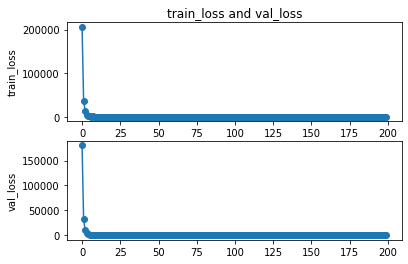

In [23]:
import matplotlib.pyplot as plt

x = range(0, N)
y1 = train_loss
#y2 = train_accu
y3 = val_loss
#y4 = val_accu
plt.subplot(2, 1, 1)
plt.plot(x, y1, 'o-')
plt.title('train_loss and val_loss')
plt.ylabel('train_loss')
#plt.subplot(2, 1, 2)
#plt.plot(x, y2, '.-')
#plt.xlabel('epoches')
#plt.ylabel('train_accu')
plt.subplot(2, 1, 2)
plt.plot(x, y3, 'o-')
plt.ylabel('val_loss')
#plt.subplot(2, 2, 2)
#plt.plot(x, y4, '.-')
#plt.title('val_loss and val_accu')
#lt.ylabel('val_accu')
plt.show()
#plt.savefig("accuracy_loss.jpg")


In [18]:
print(y1)

[206213.171875, 37132.7421875, 14051.8125, 4416.900390625, 1641.314453125, 2100.0693359375, 468.6553955078125, 634.8339233398438, 243.12722778320312, 147.85247802734375, 120.0728988647461, 82.82061004638672, 399.6026611328125, 150.54745483398438, 94.3014144897461, 77.9012451171875, 121.16570281982422, 46.111175537109375, 36.33430480957031, 36.094947814941406, 22.20563507080078, 45.298851013183594, 136.17787170410156, 240.95834350585938, 27.374732971191406, 148.73696899414062, 28.890090942382812, 64.2821044921875, 27.063749313354492, 25.344709396362305, 25.663436889648438, 28.642070770263672, 25.261577606201172, 18.551523208618164, 24.35079574584961, 15.517387390136719, 17.640771865844727, 11.507230758666992, 10.235223770141602, 36.563568115234375, 13.533258438110352, 16.294471740722656, 28.648353576660156, 16.033096313476562, 24.03493309020996, 20.05409812927246, 10.780073165893555, 13.085795402526855, 19.012117385864258, 24.211013793945312, 13.45170783996582, 62.36052703857422, 21.370

In [18]:
print(train_loss)

[173845.4375, 27468.75390625, 10986.01171875, 8614.0, 2530.158935546875, 7346.9853515625, 435.0988464355469, 390.5280456542969, 491.464111328125, 597.4315185546875, 360.8106689453125, 220.90463256835938, 165.78131103515625, 137.06080627441406, 126.29631042480469, 115.23140716552734, 116.34619140625, 74.61404418945312, 83.20699310302734, 69.45429992675781, 174.34576416015625, 36.052459716796875, 56.7833366394043, 93.3211898803711, 70.68205261230469, 49.231346130371094, 114.71270751953125, 59.01460266113281, 38.930625915527344, 59.474212646484375, 44.47710418701172, 29.397390365600586, 31.94290542602539, 184.93821716308594, 23.831289291381836, 36.786495208740234, 32.557037353515625, 38.784297943115234, 49.918880462646484, 27.44345474243164, 27.41914176940918, 33.53113555908203, 24.02131462097168, 44.385955810546875, 42.821128845214844, 48.361602783203125, 57.12141036987305, 33.137367248535156, 31.34054946899414, 21.250469207763672, 11.644176483154297, 19.558609008789062, 30.7655239105224

In [25]:
print(y3)

[47070.75850833333, 14160.651023958333, 9504.357263541666, 5064.385265625, 3622.789198177083, 2555.7030783854166, 2865.3562497395833, 1652.871702669271, 1416.6655591796875, 2500.3363373697916, 1207.1820396484375, 824.034502734375, 846.8916470052084, 772.3470776692708, 959.6251580729166, 690.0691931640625, 706.3094733723958, 439.104155859375, 455.1469000325521, 599.4429361979167, 347.8273849609375, 325.42639397786456, 351.883117578125, 539.8078697916667, 335.9686100911458, 304.3679769856771, 294.8450935546875, 257.3579281901042, 332.04665408528643, 238.25290834147137, 273.2392374348958, 517.3467895996093, 242.07539473470052, 270.023981656901, 337.67350498046875, 307.2629343424479, 512.965322672526, 395.36957345377607, 242.02395505371095, 147.75177530924478, 285.53247884114586, 208.88724529622397, 163.93382548828126, 145.00982801513672, 144.96418704427083, 170.4312279296875, 179.63603095703124, 157.23783223470053, 145.18841010742187, 139.32339187825522, 150.5882546875, 1176.737731640625,

In [19]:
print(val_loss)

[181979.66914166667, 32215.818416666665, 11730.391296875, 4787.246684895833, 2867.4116674479164, 1800.5753740885416, 1239.1841615234375, 858.0065401367187, 687.8346521809896, 532.5247006184895, 490.5320107421875, 384.09425708007814, 376.20339505208335, 322.24054611002606, 244.92048046875, 197.0757106282552, 186.27321959635415, 141.62564188639323, 128.69822504882814, 122.32585799153645, 134.1188611653646, 95.85387399902343, 97.51727214355469, 78.99045674235026, 83.40176730550131, 91.94596044921875, 116.68127329915364, 99.20418259277344, 55.42262550455729, 60.35730735677083, 61.36229677327474, 52.39097926025391, 77.13936588948567, 112.76914080403645, 48.539888366699216, 41.327950459798174, 44.41978152669271, 45.72537576497396, 41.78614848632812, 35.94390874633789, 41.33123274129232, 42.30216372070313, 30.213166573079427, 33.32122697143555, 66.61842851765951, 31.243486114501952, 34.99912432657877, 30.21335506286621, 31.69533111368815, 31.730119434611, 33.88340069986979, 31.494467423502606

In [24]:
model.eval()

BaselineModel(
  (conv1): Conv1d(1, 32, kernel_size=(9,), stride=(2,))
  (conv2): Conv1d(32, 64, kernel_size=(9,), stride=(2,))
  (conv3): Conv1d(64, 128, kernel_size=(9,), stride=(2,))
  (fc1): Linear(in_features=7040, out_features=2, bias=True)
)

In [19]:
model.eval()
test_loss = list()
for data in testloader:
    losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in testloader])
    test_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    test_loss.append(test_loss1)

In [20]:
import matplotlib.pyplot as plt

In [21]:
print(test_loss)

[4.032341237338084, 4.032341227394111, 4.032341205375316, 4.032341232366098, 4.032341229998486, 4.032341203007703, 4.0323412176869, 4.032341234260188, 4.0323412259735445, 4.032341229761724, 4.032341209163495, 4.032341186197654, 4.032341240652742, 4.032341231182292, 4.032341232366098, 4.032341234970471, 4.0323412065591215, 4.032341224789738, 4.032341206085599, 4.0323412120046305, 4.0323412141354815, 4.032341214609004, 4.032341208453212, 4.032341218397184, 4.032341236391039, 4.032341224552977, 4.0323412411262645, 4.03234123283962, 4.0323412141354815, 4.0323412541481325, 4.032341218397184, 4.032341258883358, 4.0323412217118415, 4.032341230708769, 4.032341220291274, 4.032341202297419, 4.032341212951676, 4.032341223605932, 4.032341224316215, 4.032341219817751, 4.032341221001558, 4.032341259830403, 4.032341208689973, 4.032341224789738, 4.032341244914444, 4.032341234970471, 4.0323412217118415, 4.0323412281043955, 4.032341207032644, 4.032341202770941, 4.032341205138554, 4.0323412411262645, 4.0

Text(0, 0.5, 'test_loss')

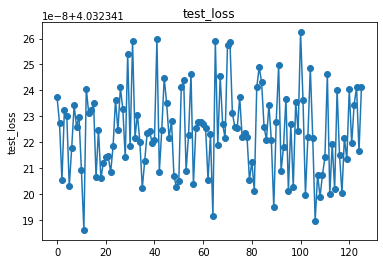

In [22]:
x = range(0, 126)
y3 = test_loss
plt.plot(x, y3, 'o-')
plt.title('test_loss')
plt.ylabel('test_loss')

In [ ]:
for data in testloader:
    inputs, lablels = data
    predictions = model(inputs.float())
    loss = loss_function(predictions,labels)
    loss = loss/128
    print("loss",loss)
    print("predicted parameter:", predictions)
    print("setting parameter:", labels)

In [ ]:
testdataset = ra.read('atomsroa.ra')
testdata = torch.tensor(testdataset)
testdata = testdata.imag
label1 = ra.read('paramsroa.ra')
label1 = torch.tensor(label1)

In [ ]:
for i in range(8056):
    inputs = testdata[:,i]
    lablels = label1[0,i]
    predictions = model(inputs.float())

    print("predicted parameter:", predictions)
    print("setting parameter:", lablels)

## Saving models

Being able to train a model is fine, but in practice once we've trained the model we probably want to save the result so we can reuse it at a later time. PyTorch makes saving the model easy using the torch.save(state, filepath) function. This will save the weights of the model so they can be loaded into a new instance at a later point.

Run the following code to save the weights for use in the next part of the lab.

In [17]:
#save the trained model weights
torch.save(model.state_dict(), "./MRF.weights")

If you are running on Colab, run the following to download the weights to the local machine:

In [ ]:
from google.colab import files
files.download('BaselineModel.weights')

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BaselineModel(1000, 512, 256).to(device)
model.load_state_dict(torch.load('BaselineModel.weights'))